In [1]:
# 画像のファイル名から正解ラベルを作る
# まずはモジュールのインポート
import re
import random
import pathlib
import numpy as np
import keras
from keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
class makeDataSet:
    # インスタンス変数の定義とファイル名の取得
    def __init__(self, img_dir, img_size):
        self.img_size = img_size
        self.img_dir_obj = pathlib.Path(img_dir)
        self.img_all_list = list(self.img_dir_obj.glob('O*.png'))
        self.img_all_list = random.sample(self.img_all_list, len(self.img_all_list))
        self.x = []
        self.y = []
        self.dent = [
            11, 12, 13, 14, 15, 16, 17, 18,
            21, 22, 23, 24, 25, 26, 27, 28,
            31, 32, 33, 34, 35, 36, 37, 38,
            41, 42, 43, 44, 45, 46, 47, 48]


    # 画像をnp配列に変換
    def imageToArray(self, img_list):
        for fn in img_list:
            img_array = img_to_array(load_img(fn))
            self.x.append(img_array)
        self.x = np.asarray(self.x, dtype=np.float32)
        self.x /= 255.0
        return self.x


    # ファイル名をk-hotエンコーディング
    def k_hot_encode(self, img_list):
        for fn in img_list:
            k_hot_teeth = [0.0]*32
            fn = re.sub('.*-', '', str(fn)).strip('.png').split(',')
            fn = [float(k) for k in fn]
            for tooth in fn:
                if tooth in self.dent:
                    k_hot_teeth[self.dent.index(tooth)] = 1.0
            self.y.append(k_hot_teeth)
        self.y = np.asarray(self.y, dtype=np.float32)
        return self.y


    # 使用する画像の枚数を指定
    def pickupImages(self, pick_num):
        self.pickup_img = self.img_all_list[:pick_num]
        return self.pickup_img
    
    
    # 画像サイズを変更したいとき
    def adjustedImgArray(self, img_list):
        for fn in img_list:
            ad_img = keras.preprocessing.image.load_img(fn, target_size=(self.img_size, self.img_size))
            ad_img_array = img_to_array(ad_img)
            self.x.append(ad_img_array)
        self.x = np.asarray(self.x, dtype=np.float32)
        self.x /= 255.0    
        return self.x

    
    #  訓練データと確認データを切り分ける
    def devideData(self, img_array, img_label, test_size):
        x_train, x_test, y_train, y_test = train_test_split(img_array, img_label, test_size=test_size)
        return x_train, x_test, y_train, y_test

In [4]:
img_dir = '/Users/seino/Documents/research/DeepLearning/playground/multiclass_multilabel_5/32'
ds = makeDataSet(img_dir, 32)
'''
img_list = ds.pickupImages(5000)
img_array = ds.adjustedImgArray(img_list)
img_label = ds.k_hot_encode(img_list)
'''
img_list = ds.img_all_list
img_array = ds.adjustedImgArray(img_list)
img_label = ds.k_hot_encode(img_list)

test_size = 0.2
x_train, x_test, y_train, y_test = ds.devideData(img_array, img_label, test_size)

(26890, 32, 32, 3)
(26890, 32)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0.
 0. 1. 1. 0. 1. 0. 0. 1.]


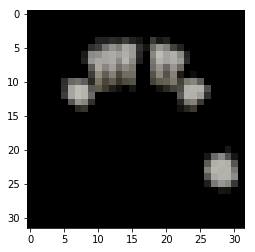

In [5]:
# 可視化して確認
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

print(x_train.shape)
print(y_train.shape)
print(y_train[0])
plt.imshow(x_train[0])
plt.show()

In [6]:
# 機械学習に必要なモジュールをインポートする
import keras
from keras import layers
from keras import models
from keras.utils import plot_model
from keras.models import load_model
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D

In [7]:
# 画像のサイズ定義
img_size = ds.img_size
height, width, channels = img_size, img_size, 3
class_num = len(ds.dent) # 歯種がクラスになる

In [8]:
# モデルの構築
model = models.Sequential()
model.add(layers.SeparableConv2D(img_size, 3, activation='relu', input_shape=(height, width, channels)))
model.add(layers.SeparableConv2D(img_size*2, 3, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.MaxPooling2D(2))

model.add(layers.SeparableConv2D(img_size*2, 3, activation='relu'))
model.add(layers.SeparableConv2D(img_size*4, 3, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.MaxPooling2D(2))

model.add(layers.SeparableConv2D(img_size*4, 3, activation='relu'))
model.add(layers.SeparableConv2D(img_size*8, 3, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.GlobalAveragePooling2D())

model.add(layers.Dense(img_size*4, activation='relu'))
model.add(layers.Dense(img_size*2, activation='relu'))
model.add(layers.Dense(class_num, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy',metrics=['acc'])
model.summary()

W1010 16:02:51.106271 4823977280 deprecation_wrapper.py:119] From /Users/seino/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1010 16:02:51.113120 4823977280 deprecation.py:506] From /Users/seino/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W1010 16:02:51.394041 4823977280 deprecation.py:323] From /Users/seino/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast r

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_1 (Separabl (None, 30, 30, 32)        155       
_________________________________________________________________
separable_conv2d_2 (Separabl (None, 28, 28, 64)        2400      
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
separable_conv2d_3 (Separabl (None, 12, 12, 64)        4736      
_________________________________________________________________
separable_conv2d_4 (Separabl (None, 10, 10, 128)       8896      
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 10, 128)       0         
__________

In [9]:
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor='val_acc',
        patience=1
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='callbacks.h5',
        monitor='val_acc',
        save_best_only=True,
    ),
    keras.callbacks.TensorBoard(
        log_dir='./log',
        histogram_freq=1,
        batch_size=32,
        write_graph=True,
        write_grads=False,
        embeddings_freq=1,
        embeddings_layer_names=None,
        embeddings_metadata=None
    )
]

In [10]:
history = model.fit(
    x_train, y_train, batch_size=50,
    epochs=10, validation_data = (x_test, y_test), verbose=1
)

W1010 16:03:00.313945 4823977280 deprecation_wrapper.py:119] From /Users/seino/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W1010 16:03:00.320773 4823977280 deprecation_wrapper.py:119] From /Users/seino/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.

W1010 16:03:00.537454 4823977280 deprecation_wrapper.py:119] From /Users/seino/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:2741: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W1010 16:03:00.542713 4823977280 deprecation_wrapper.py:119] From /Users/seino/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.



Train on 26890 samples, validate on 6723 samples
Epoch 1/10
26890/26890 [==============================] - 36s 1ms/step - loss: 0.5052 - acc: 0.7614 - val_loss: 0.3601 - val_acc: 0.7871
Epoch 2/10
26890/26890 [==============================] - 39s 1ms/step - loss: 0.3114 - acc: 0.8244 - val_loss: 0.2528 - val_acc: 0.8709
Epoch 3/10
26890/26890 [==============================] - 41s 2ms/step - loss: 0.2273 - acc: 0.8790 - val_loss: 0.1917 - val_acc: 0.9082
Epoch 4/10
26890/26890 [==============================] - 36s 1ms/step - loss: 0.1680 - acc: 0.9162 - val_loss: 0.1443 - val_acc: 0.9404
Epoch 5/10
26890/26890 [==============================] - 34s 1ms/step - loss: 0.1361 - acc: 0.9335 - val_loss: 0.1133 - val_acc: 0.9515
Epoch 6/10
26890/26890 [==============================] - 36s 1ms/step - loss: 0.1166 - acc: 0.9442 - val_loss: 0.0884 - val_acc: 0.9622
Epoch 7/10
26890/26890 [==============================] - 37s 1ms/step - loss: 0.0978 - acc: 0.9552 - val_loss: 0.0712 - val_acc:

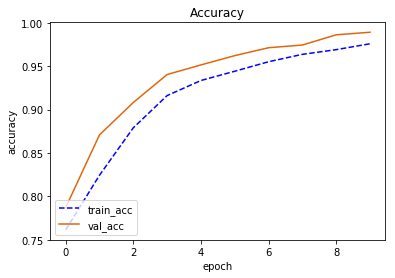

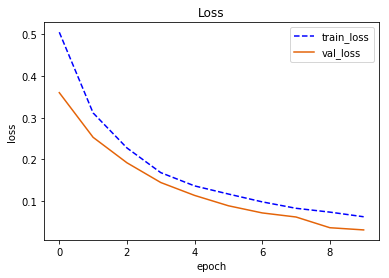

In [11]:
model.save('./re' + str(img_size) + '/model.h5')

train_acc = history.history['acc']
val_acc = history.history['val_acc']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_acc, linestyle='--', color='b')
plt.plot(val_acc, linestyle='-', color='#e46409')
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train_acc', 'val_acc'], loc='lower left')
plt.savefig('./re' + str(img_size) + '/graph/acc.png')
plt.show()

plt.plot(train_loss, linestyle='--', color='b')
plt.plot(val_loss, linestyle='-', color='#e46409')
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train_loss', 'val_loss'], loc='upper right')
plt.savefig('./re' + str(img_size) + '/graph/loss.png')
plt.show()

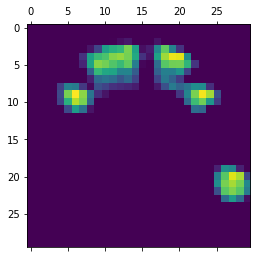

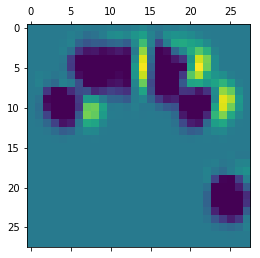

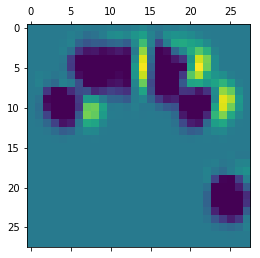

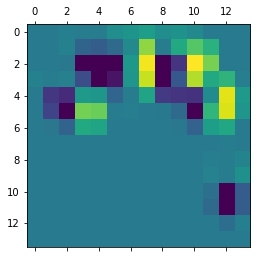

In [12]:
# 活性化マップを可視化する。
layer_outputs = [layer.output for layer in model.layers[:5]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(x_train)
first_layer_activation = activations[:4]
for i, act in enumerate(first_layer_activation):
    plt.matshow(act[0, :, :, 3], cmap='viridis')
    plt.savefig('./re' + str(img_size) + '/activation/act-' + str(i) + '.png')
    plt.show()

/Users/seino/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


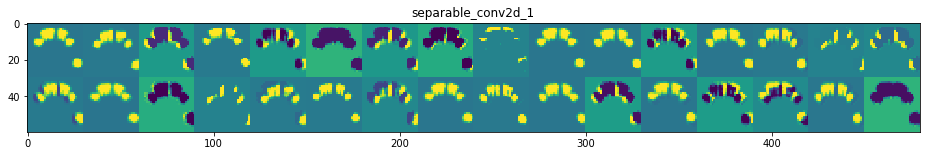

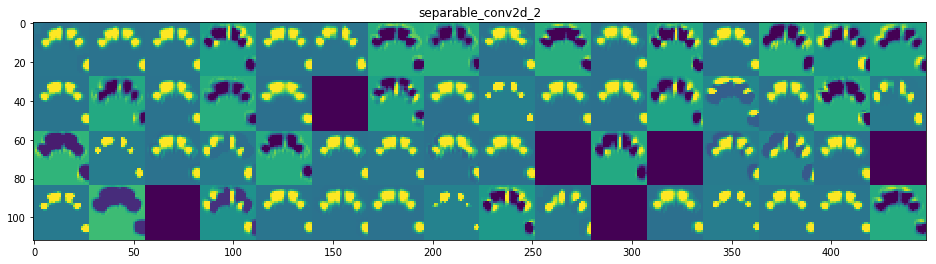

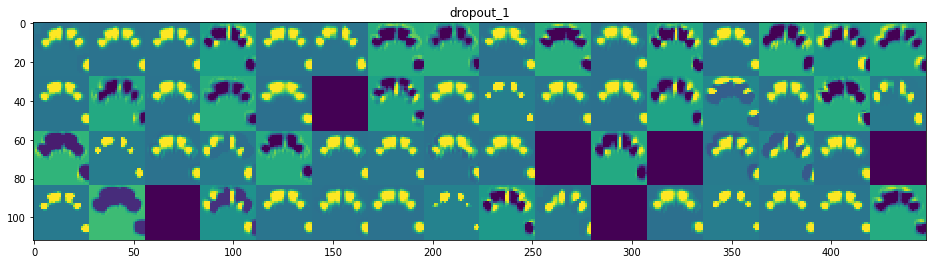

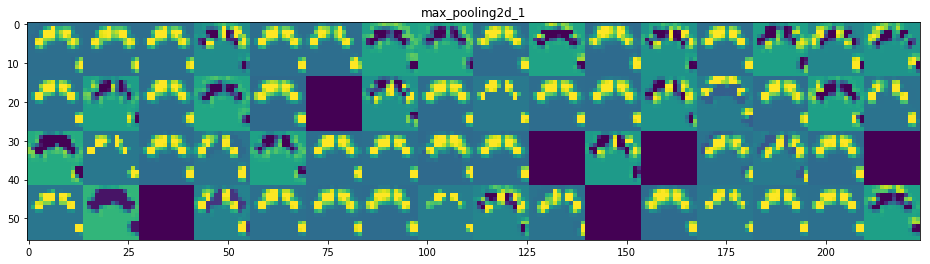

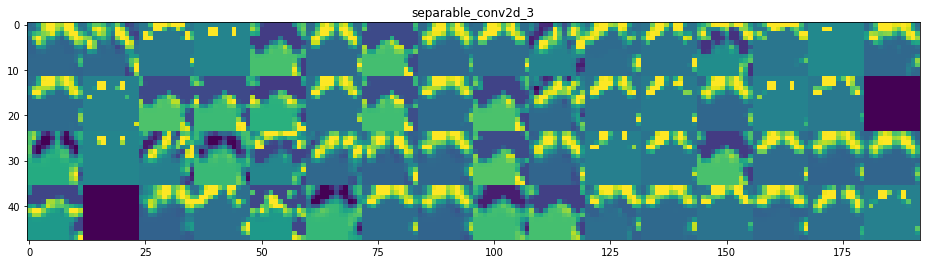

In [13]:
# 各レイヤーの名前を抽出
layer_names = []
for layer in model.layers:
    layer_names.append(layer.name)

# 一行に表示する画像の数
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    # レイヤーの特徴マップ数を取得
    n_features = layer_activation.shape[-1]
    # 特徴マップのサイズを取得
    size = layer_activation.shape[1]
    # 画像の行数を計算し画像を並べる0行列を生成
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            # 特徴マップを標準化
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            # 平均128、標準偏差64に変換
            channel_image *= 64
            channel_image += 128
            # 0-255に符号なし8ビット整数化
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            # 所定の位置にイメージを埋め込む
            display_grid[col * size : (col + 1) * size, row * size: (row +1) * size ] = channel_image
    # 画像の表示
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    plt.savefig('./re' + str(img_size) + '/feature/' + layer_name + '.png')
plt.show()

以下、学習モデルを用いて、ヒートマップを作成する。

/Users/seino/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide
/Users/seino/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/seino/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:395: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/Users/seino/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:396: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/Users/seino/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:403: UserWarning: Warning: converting a masked element to nan.
  a_min = np.fl

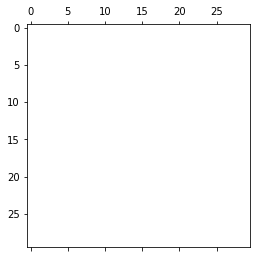

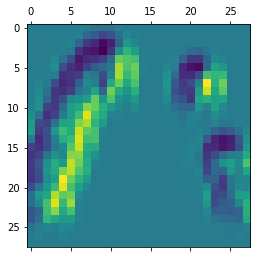

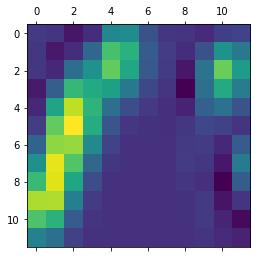

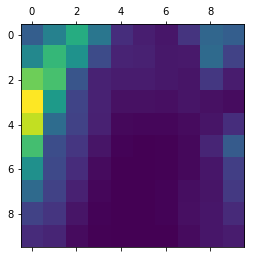

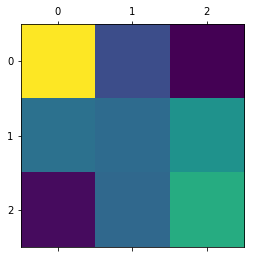

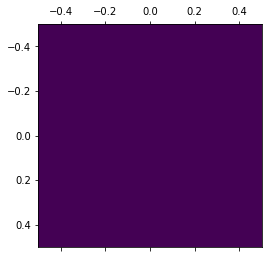

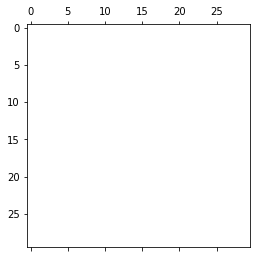

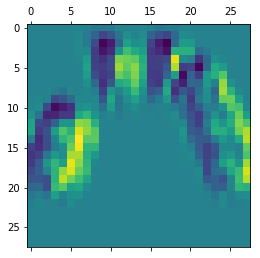

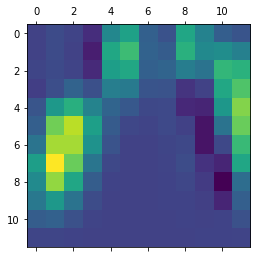

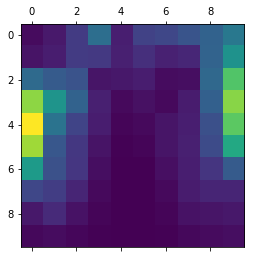

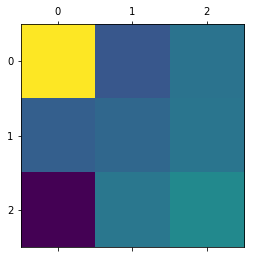

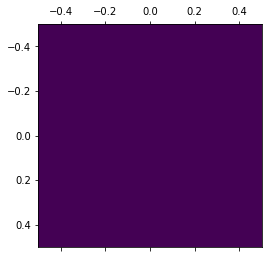

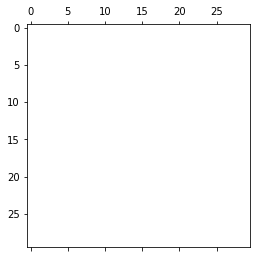

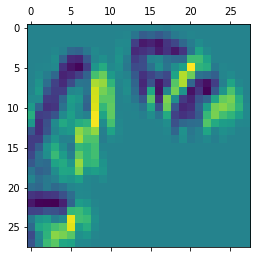

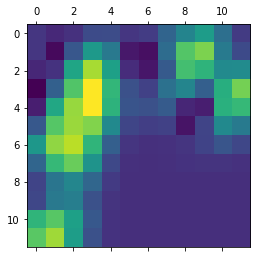

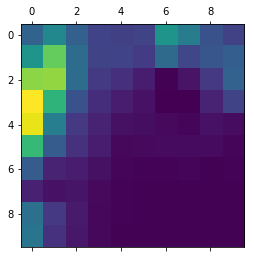

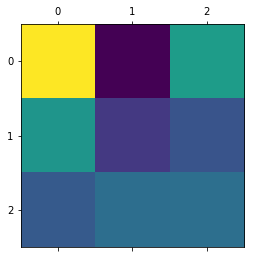

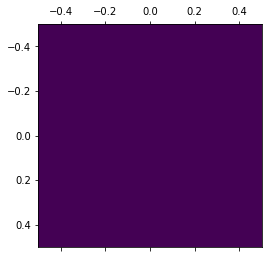

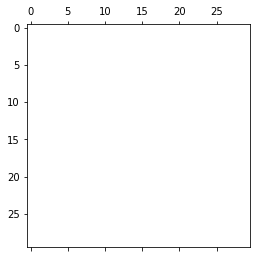

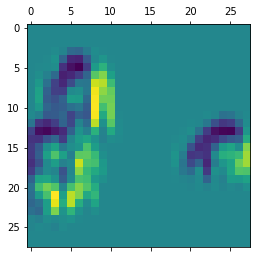

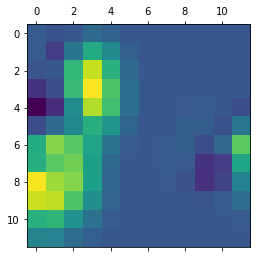

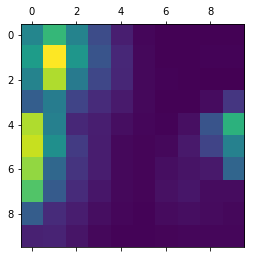

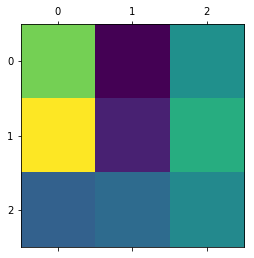

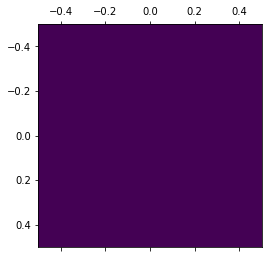

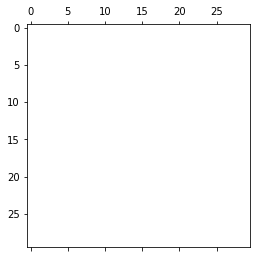

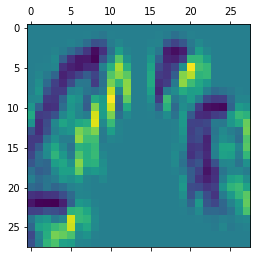

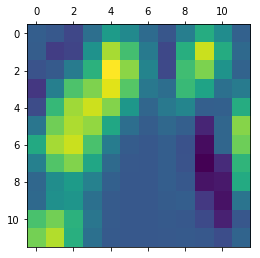

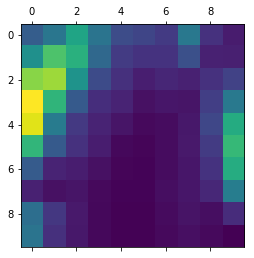

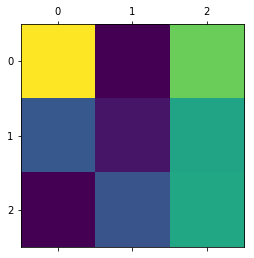

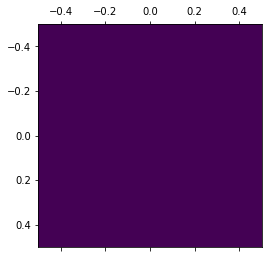

In [14]:
# 学習モデルを用いて、ヒートマップと元の画像を重ねて表示する
import cv2
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

# ヒートマップとしてほしい画像の数
heat_num = 5
# ターゲット画像へのローカルパスは、ds.img_all_list[:heat_num]
for path in ds.img_all_list[:heat_num]:
    # 読み込み
    img = image.load_img(path, target_size=(ds.img_size, ds.img_size))
    # 画像を配列に変換
    img_np = image.img_to_array(img)
    # バッチに変換するために次元を追加
    img_np = np.expand_dims(img_np, axis=0)
    # 前処理。チャネルごとに色を正規化
    img_np = preprocess_input(img_np)
    # 画像に対する予測
    preds = model.predict_classes(img_np)
    pred_class = np.argmax(preds[0])
    # 予測ベクトルはpred_class
    dent_output = model.output[:, pred_class]
    # 畳み込み層を取得
    for layer in [n for n in layer_names if 'conv' in n]:
        conv_layer = model.get_layer(layer)
        # 特徴マップの勾配を取得
        grads = keras.backend.gradients(dent_output, conv_layer.output)[0]
        # 形状が(32,)のベクトル
        # 各ラベルは特定の特徴マップチャネルの勾配の平均強度
        pooled_grads = keras.backend.mean(grads, axis=(0, 1, 2))
        # サンプル画像に基づいて、平均強度と特徴出力マップにアクセス
        iterate = keras.backend.function([model.input], [pooled_grads, conv_layer.output[0]])
        # 上記をnumpy配列に
        pooled_grads_value, conv_layer_output_value = iterate([img_np])
        # このクラスに対するチャネルの重要度を特徴マップに重み付け
        for p in range(32):
            conv_layer_output_value[:, :, p] *= pooled_grads_value[p]
        # 最終的な特徴マップのチャネルごとの平均値がクラスの活性化ヒートマップになる
        heatmap = np.mean(conv_layer_output_value, axis=-1)
        # ヒートマップの後処理
        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap)
        plt.matshow(heatmap)        
        # 元画像の読み込み
        img_cv = cv2.imread(str(path))
        # ヒートマップのサイズと元画像のサイズを合わせる
        heatmap = cv2.resize(heatmap, (img_cv.shape[1], img_cv.shape[0]))
        # ヒートマップをRGBに変換
        heatmap = np.uint8(255 * heatmap)
        # ヒートマップを元画像に適応
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        # 透明度n%でスーパーインポーズ
        superimposed_heatimg = heatmap * 0.4 + img_cv
        fn_core = re.sub('.*-', '', str(path)).strip('\].png').split(',')
        dst = str(layer) + '_' + str(fn_core) + '.png'
        cv2.imwrite('./re' + str(img_size) + '/heatmap/' + dst, superimposed_heatimg)